In [1]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
%matplotlib inline
import os



def SearchID(df, ident):
    return df[df['id'] == ident]

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Introducir una lista con todo el directorio ###

dire = [
    'listings_adv_0319.csv',
    'listings_adv_0419.csv',
    'listings_adv_0519.csv',
    'listings_adv_0619.csv',
    'listings_adv_0719.csv',
    'listings_adv_0819.csv',
    'listings_adv_0919.csv',
    'listings_adv_1019.csv',
    'listings_adv_1119.csv',
    'listings_adv_1219.csv',
    'listings_adv_0120.csv',
    'listings_adv_0220.csv',
    'listings_adv_0320.csv'
]

### Pre-Processing

### Leer el Csv ###

listados_total = [pd.read_csv(d, low_memory = False) for d in dire]

listados_total[0].head()

### Establecer cuales son las variables redundantes y guardarlas en una lista ###

variables_red = ['listing_url', 'name', 'summary', 
            'space', 'description',
            
            'experiences_offered',
            'neighborhood_overview', 'notes', 'transit',
            'access', 'interaction', 'house_rules',
                 
            'thumbnail_url',
            'medium_url', 'picture_url', 'xl_picture_url',
                 
            'host_url', 'host_name',
            'host_about',
            'host_thumbnail_url', 'host_picture_url','host_listings_count',
            'host_verifications', 
                 
            'street','neighbourhood_group_cleansed',
            'city','state','market','smart_location','country_code', 'country',
                 
            'bed_type',
                 
            
             'maximum_nights', 'minimum_minimum_nights',
            'maximum_minimum_nights', 'minimum_maximum_nights',
            'maximum_maximum_nights',
                 
                 
            'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
            'calculated_host_listings_count_private_rooms',
            'calculated_host_listings_count_shared_rooms',
                 
            'host_response_time',
            'host_acceptance_rate',
            'scrape_id',
            'host_neighbourhood',
            'square_feet',
            'weekly_price',
            'monthly_price',
            'minimum_nights_avg_ntm',
            'maximum_nights_avg_ntm',
            'calendar_updated',
            'availability_30',
            'availability_60',
            'availability_90',
            'availability_365','calendar_last_scraped','requires_license',
            'license',
            'jurisdiction_names'   
            
                ]

# Quitar variables redundantes para el análisis

for l in listados_total:
    l.drop(columns=variables_red, inplace=True)

### Renombrar ###

for lis in listados_total:
    lis.rename(columns={'neighbourhood':'colonia',
                        'neighbourhood_cleansed':'alcaldía',
                        'zipcode':'código_postal',
                        'room_type':'tipo_cuarto',
                        'price':'precio',
                        'instant_bookable':'insta_book',
                        }, inplace = True)

##### Primero hay que limpiar los precios, es decir, quitarle el signo y puntuación y convertirlo a tipo flotante #####

### Establecer varaibles de precio

prices = ['precio','cleaning_fee','extra_people', 'security_deposit']

for lista in listados_total:
    for p in prices:
        lista[p] = lista[p].str.replace('$','')
        lista[p] = lista[p].str.replace(',','')
        lista[p] = pd.to_numeric(lista[p])



### Número de NAs de colonia ###

### Número de listados por scrape ###

no_listados = []
for i in listados_total:
        x = 0
        x += x + int(i.shape[0])
        no_listados.append(i.shape[0])
        

no_listados

#  Unir todas las bases en una sola

listados_panel = pd.concat(listados_total)

#### Ordenar el df por id y fecha de scrapeo ###

listados_panel.sort_values(by=['id', 'last_scraped'], inplace=True)

listados_panel.drop_duplicates(subset=['id', 'last_scraped'], inplace=True)

##### Crear variable comercial, es decir, si el dueño del listado tiene más de uno, es comercial, si es sólo uno, entonces es privado

listados_panel['Tipo Listado'] = np.where(listados_panel['host_total_listings_count'] > 1, 'Comercial', 'Privado')

# Convertir variabla a datetime

listados_panel['last_scraped'] = pd.to_datetime(listados_panel['last_scraped'])

listados_panel['host_since'] = pd.to_datetime(listados_panel['host_since'])

listados_panel['mes'] = pd.to_datetime(listados_panel['last_scraped']).dt.to_period('M')

reviews  = pd.read_csv("reviews_clean.csv")

reviews.rename(columns={'reviews_per_month':'reviews_per_month_2'}, inplace=True)

reviews.info()

reviews.drop('Unnamed: 0', axis = 1, inplace = True)

reviews.mes = pd.to_datetime(reviews.mes)

listados_panel.mes = listados_panel.mes.astype('str')

listados_panel.mes = pd.to_datetime(listados_panel.mes)

#### Agregar datos de número de reseñas por mes por listado a la base de datos principal ###

listados_panel = listados_panel.merge(reviews, on=['mes', 'id'], how = 'left')

### Estimar la ocupación de los listados

### Primero hay que estimar el número de noches promedio de los huéspedes en la CDMX. 4 noches, según el Financiero en 2017.

noches_promedio = 4

### Luego hay que calcular la tasa de reviews (Inside Airbnb/Murray Cox)

tasa_reviews_1 = 0.5

tasa_reviews_2 = 0.4

listados_panel['occupancy_rate_1'] = round(noches_promedio*(listados_panel['reviews_per_month']/tasa_reviews_1), 2)

listados_panel['occupancy_rate_2'] = round(noches_promedio*(listados_panel['reviews_per_month']/tasa_reviews_2), 2)

listados_panel['occupancy_rate_3'] = round(noches_promedio*(listados_panel['reviews_per_month_2']/tasa_reviews_1), 2)

### Quitamos outliers que no cumplen con las condiciones

len(listados_panel[listados_panel['occupancy_rate_1'] > 100])

listados_panel.drop(listados_panel[(listados_panel['occupancy_rate_1'] > 100)].index, axis=0, inplace=True)
listados_panel.occupancy_rate_1.describe()

ids_hoteles = list(listados_panel[listados_panel['tipo_cuarto'] == 'Hotel room']['id'])
indices = list(listados_panel[listados_panel['id'].isin(ids_hoteles)].sort_values(by='id')['tipo_cuarto'].index)

listados_panel.loc[indices,'tipo_cuarto'] = 'Hotel room'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91573 entries, 0 to 91572
Data columns (total 4 columns):
Unnamed: 0             91573 non-null int64
id                     91573 non-null int64
reviews_per_month_2    91573 non-null int64
mes                    91573 non-null object
dtypes: int64(3), object(1)
memory usage: 2.8+ MB


In [2]:
listados_panel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259209 entries, 0 to 259388
Data columns (total 53 columns):
id                                  259209 non-null int64
last_scraped                        259209 non-null datetime64[ns]
host_id                             259209 non-null int64
host_since                          259040 non-null datetime64[ns]
host_location                       258178 non-null object
host_response_rate                  209878 non-null object
host_is_superhost                   259040 non-null object
host_total_listings_count           259040 non-null float64
host_has_profile_pic                259040 non-null object
host_identity_verified              259040 non-null object
colonia                             203796 non-null object
alcaldía                            259209 non-null object
código_postal                       244452 non-null object
latitude                            259209 non-null float64
longitude                           259209 non-

In [4]:
listados_panel['occupancy_rate_1'].describe()

count    198419.000000
mean         13.916967
std          14.195253
min           0.080000
25%           3.360000
50%           8.880000
75%          20.000000
max         100.000000
Name: occupancy_rate_1, dtype: float64

In [5]:
listados_panel['occupancy_rate_3'].describe()

count    90409.000000
mean        23.281930
std         17.696107
min          8.000000
25%          8.000000
50%         16.000000
75%         32.000000
max        192.000000
Name: occupancy_rate_3, dtype: float64

In [6]:
listados_panel.amenities = listados_panel.amenities.str.replace("[{}]", "").str.replace('"', "").str.replace(' ','_').str.replace(' ','')

In [59]:
for i in listados_panel.amenities:
    listados_pa = i.split(',')

In [63]:
listados_panel.amenities = listados_panel.amenities.str.split(',')

In [8]:
listados_panel.amenities[1]

'Wifi,Kitchen,Free_parking_on_premises,Smoking_allowed,Elevator,Washer,Essentials,Hangers,Hair_dryer,Laptop_friendly_workspace,High_chair,Hot_water,Refrigerator,Dishes_and_silverware,Cooking_basics,Oven,Patio_or_balcony,Long_term_stays_allowed,Host_greets_you'

In [12]:
listados_panel['has_wifi'] = listados_panel['amenities'].str.contains('Wifi')

In [20]:
listados_panel['has_wifi'].value_counts()

True     251186
False      8023
Name: has_wifi, dtype: int64

In [17]:
listados_panel['allows_pets'] = listados_panel['amenities'].str.contains('Pets_allowed')

In [19]:
listados_panel['allows_pets'].value_counts()

False    214567
True      44642
Name: allows_pets, dtype: int64

In [28]:
listados_panel['has_gym'] = listados_panel['amenities'].str.contains('Pool')

In [29]:
listados_panel['has_gym'].value_counts()

False    241411
True      17798
Name: has_gym, dtype: int64

In [30]:
listados_panel['has_breakfast'] = listados_panel['amenities'].str.contains('Breakfast')

In [31]:
listados_panel['has_breakfast'].value_counts()

False    233122
True      26087
Name: has_breakfast, dtype: int64

In [32]:
listados_panel['is_family_friendly'] = listados_panel['amenities'].str.contains('Family/kid_friendly')

In [33]:
listados_panel['is_family_friendly'].value_counts()

False    199619
True      59590
Name: is_family_friendly, dtype: int64

In [34]:
listados_panel['has_kitchen'] = listados_panel['amenities'].str.contains('Kitchen')

In [35]:
listados_panel['has_kitchen'].value_counts()

True     234044
False     25165
Name: has_kitchen, dtype: int64

In [36]:
listados_panel['has_washer'] = listados_panel['amenities'].str.contains('Washer')

In [37]:
listados_panel['has_washer'].value_counts()

True     156756
False    102453
Name: has_washer, dtype: int64

In [38]:
listados_panel['has_dryer'] = listados_panel['amenities'].str.contains('Dryer')

In [39]:
listados_panel['has_dryer'].value_counts()

False    157559
True     101650
Name: has_dryer, dtype: int64

In [40]:
listados_panel['has_parking'] = listados_panel['amenities'].str.contains('Free_parking_on_premises')

In [41]:
listados_panel['has_parking'].value_counts()

False    166376
True      92833
Name: has_parking, dtype: int64

In [46]:
listados_panel['has_laptop_workspace'] = listados_panel['amenities'].str.contains('Laptop_friendly_workspace')

In [47]:
listados_panel['has_laptop_workspace'].value_counts()

True     191110
False     68099
Name: has_laptop_workspace, dtype: int64

In [48]:
listados_panel['has_HBO'] = listados_panel['amenities'].str.contains('HBO_GO')

In [50]:
listados_panel['has_HBO'].value_counts()

False    259147
True         62
Name: has_HBO, dtype: int64

In [51]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact','has_availability', 'insta_book',
            'is_business_travel_ready',
                   'require_guest_profile_picture', 'require_guest_phone_verification']
for c in columns:
    listados_panel[c] = listados_panel[c].replace('f',0,regex=True)
    listados_panel[c] = listados_panel[c].replace('t',1,regex=True)

In [55]:
columns_amenities = ['has_wifi', 'has_breakfast', 'has_washer', 'allows_pets', 'is_family_friendly', 'has_dryer', 'has_gym',
                    'has_kitchen', 'has_parking', 'has_HBO', 'has_laptop_workspace']

for c in columns_amenities:
    listados_panel[c] = listados_panel[c].replace(False, 0, regex=True)
    listados_panel[c] = listados_panel[c].replace(True, 1, regex=True)


In [41]:
listados_panel.to_csv('listados_1.csv',encoding='latin1')

In [43]:
listados_panel.mes.value_counts()

2020-03-01    21790
2020-02-01    21643
2020-01-01    21459
2019-12-01    21142
2019-11-01    20557
2019-10-01    20556
2019-09-01    20257
2019-08-01    20020
2019-07-01    19348
2019-06-01    19020
2019-05-01    18338
2019-04-01    17857
2019-03-01    17222
Name: mes, dtype: int64

In [65]:
listados_panel['first_review'] = pd.to_datetime(listados_panel['first_review'])

listados_panel['last_review'] = pd.to_datetime(listados_panel['last_review'])

listados_panel['meses_inact'] = ((listados_panel.last_scraped - listados_panel.last_review)/np.timedelta64(1, 'M'))


In [69]:
listados_panel.drop(listados_panel[(listados_panel['meses_inact'] > 6)].index, axis=0, inplace=True)

listados_panel.dropna(axis=0, how='any', subset =['meses_inact'], inplace=True)

In [68]:
listados_fil

In [70]:
listados_panel.isnull().sum()

id                                      0
last_scraped                            0
host_id                                 0
host_since                            128
host_location                         416
host_response_rate                   4650
host_is_superhost                     128
host_total_listings_count             128
host_has_profile_pic                  128
host_identity_verified                128
colonia                             27134
alcaldía                                0
código_postal                        7232
latitude                                0
longitude                               0
is_location_exact                       0
property_type                           0
tipo_cuarto                             0
accommodates                            0
bathrooms                               3
bedrooms                               59
beds                                  166
amenities                               0
precio                            

In [59]:
listados_panel.to_csv('listados_final.csv', encoding = 'utf-8')

In [ ]:
listados_panel_activos = 

In [71]:
listados_julio = listados_panel[listados_panel['mes'] == '2019-07-01']

In [88]:
listados_julio.isnull().sum()

id                                     0
last_scraped                           0
host_id                                0
host_since                             8
host_location                         30
host_response_rate                   416
host_is_superhost                      8
host_total_listings_count              8
host_has_profile_pic                   8
host_identity_verified                 8
colonia                             1893
alcaldía                               0
código_postal                        501
latitude                               0
longitude                              0
is_location_exact                      0
property_type                          0
tipo_cuarto                            0
accommodates                           0
bathrooms                              2
bedrooms                               2
beds                                   5
precio                                 0
security_deposit                    3977
cleaning_fee    

In [79]:
listados_julio['tipo_cuarto'].value_counts()

Entire home/apt    6620
Private room       4403
Shared room         114
Name: tipo_cuarto, dtype: int64

In [77]:
indices_hotel = listados_julio[listados_julio['tipo_cuarto'] == 'Hotel room'].index

In [78]:
listados_julio = listados_julio.drop(indices_hotel)

In [85]:
listados_julio = listados_julio.drop(axis=1, columns='amenities')

In [90]:
indices_ubis =listados_julio[listados_julio['is_location_exact'] == False].index

In [91]:
listados_julio_ubis = listados_julio.drop(indices_ubis)

In [92]:
listados_julio_ubis.is_location_exact.value_counts()

1    8174
Name: is_location_exact, dtype: int64

In [94]:
listados_julio_ubis.drop(axis=1, columns='is_location_exact', inplace=True)

In [96]:
index_calis =listados_julio_ubis[listados_julio_ubis.review_scores_rating.isnull()].index

In [97]:
listados_julio_ubis_clean = listados_julio_ubis.drop(index_calis)

In [99]:
listados_julio_ubis_clean.cleaning_fee = listados_julio_ubis_clean.cleaning_fee.fillna(0)

In [105]:
listados_julio_ubis_clean.security_deposit = listados_julio_ubis_clean.security_deposit.fillna(0)

In [107]:
listados_julio_ubis_clean['host_is_superhost'] = listados_julio_ubis_clean['host_is_superhost'].dropna()

In [118]:
listados_julio_ubis_clean['host_response_rate'] = listados_julio_ubis_clean.host_response_rate.str.replace('%','')

In [131]:
listados_julio_ubis_clean.set_index('id', inplace = True)

In [132]:
index_response = listados_julio_ubis_clean[listados_julio_ubis_clean.host_response_rate.isnull()].index

In [134]:
listados_julio_ubis_clean = listados_julio_ubis_clean.drop(index_response)

In [ ]:
listados_julio_ubis_clean = listados_julio_ubis_clean.drop(index_response)

In [138]:
listados_julio_ubis_clean.host_response_rate = pd.to_numeric(listados_julio_ubis_clean.host_response_rate)

In [140]:
listados_julio_ubis_clean.host_response_rate.describe()

count    7822.000000
mean       97.178727
std        10.096125
min         0.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.000000
Name: host_response_rate, dtype: float64

In [141]:
listados_julio_ubis_clean.isnull().sum()

last_scraped                           0
host_id                                0
host_since                             0
host_location                          8
host_response_rate                     0
host_is_superhost                      0
host_total_listings_count              0
host_has_profile_pic                   0
host_identity_verified                 0
colonia                             1183
alcaldía                               0
código_postal                        105
latitude                               0
longitude                              0
property_type                          0
tipo_cuarto                            0
accommodates                           0
bathrooms                              0
bedrooms                               1
beds                                   0
precio                                 0
security_deposit                       0
cleaning_fee                           0
guests_included                        0
extra_people    

In [143]:
listados_julio_ubis_clean.to_stata('listados_julio_final.dta', encoding='latin-1')

C:\Users\edari\Anaconda3\lib\site-packages\pandas\io\stata.py:2138: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b'alcald\xc3\xada'   ->   alcald_a
    b'c\xc3\xb3digo_postal'   ->   c_digo_postal
    b'Tipo Listado'   ->   Tipo_Listado

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


In [87]:
listados_julio['is_location_exact'].value_counts()

1    8174
0    2963
Name: is_location_exact, dtype: int64

In [144]:
listados_julio_ubis_clean.cancellation_policy.value_counts()

flexible                       3032
moderate                       2880
strict_14_with_grace_period    1910
Name: cancellation_policy, dtype: int64

In [ ]:
coords = 

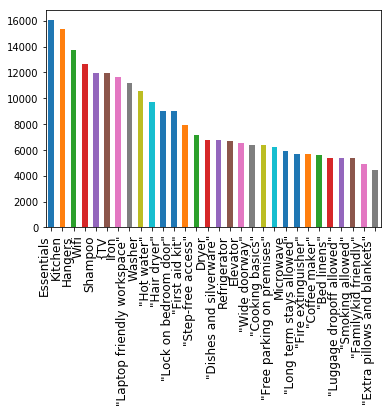

In [22]:
pd.Series(np.concatenate(listados_total[0]['amenities'].map(lambda amns: amns.split(","))))\
    .value_counts().head(30)\
    .plot(kind='bar')
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=12)
plt.show();

In [75]:
box = ((listados_panel.longitude.min(), listados_panel.longitude.max(),
       listados_panel.latitude.min(), listados_panel.latitude.max()))

In [76]:
box

(-99.34082, -98.96259, 19.15073, 19.56534)